# NLP models, analyzing sentiments and generating dataset

In [1]:
import pandas as pd
import numpy as np
import sqlalchemy as sqla
import random
import spacy
from spacy.util import minibatch, compounding
import time
from textblob import TextBlob
from matplotlib import pyplot as plt

# Sentiment Analysis

**It's important to use sentiments to evaluate the review of business. Although 'stars' seems to be a sufficient estimator, it lacks objectivity. A person can give different stars under his/her certain mood even though the actual quality of the business is constant. Thus, bringing up sentiment into account is a good way of measuring the actually quality of the business**

In [2]:
# construct connection to database
conn = sqla.create_engine('sqlite:///yelp.sqlite')

In [3]:
# query data from database
test = pd.read_sql_query("select * from review limit 20",conn)

In [156]:
test['text'][0]

"The pizza was okay. Not the best I've had. I prefer Biaggio's on Flamingo / Fort Apache. The chef there can make a MUCH better NY style pizza. The pizzeria @ Cosmo was over priced for the quality and lack of personality in the food. Biaggio's is a much better pick if youre going for italian - family owned, home made recipes, people that actually CARE if you like their food. You dont get that at a pizzeria in a casino. I dont care what you say..."

## Textblob classifier

In [93]:
%%time
# Default estimator
m = test['text'][2]
senti = TextBlob(m)
print(senti.sentiment)

Sentiment(polarity=-0.5333333333333333, subjectivity=0.8)
CPU times: user 1.4 ms, sys: 1.02 ms, total: 2.42 ms
Wall time: 3.86 ms


In [6]:
%%time
# NaiveBayes estimator:
from textblob.sentiments import NaiveBayesAnalyzer
senti = TextBlob(m,analyzer=NaiveBayesAnalyzer())
print(senti.sentiment)

Sentiment(classification='pos', p_pos=0.9136346853028313, p_neg=0.08636531469717702)
CPU times: user 4.15 s, sys: 514 ms, total: 4.66 s
Wall time: 5.23 s


**textblob doesn't have a acceptable accuracy especially for food review. Naivebayes is slow and inaccurate. I did a little research on how textblob calculates the sentiment. It turns out they have a XML file that contains polarity score for each words, and the overall polarity score is just the average of polarity scores of each word (Link: https://planspace.org/20150607-textblob_sentiment/ ). This is a poor way of estimating the sentiment score. Consider training my own NLP model.**

## SpaCy Text Categorizer    
I will train the model with Amazon's food review

In [9]:
amz_review = pd.read_csv('Amazon_Reviews.csv')
amz_review.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [17]:
# rescale score between -1 and 1
norm_score = np.interp(amz_review.Score.values,(amz_review.Score.values.min(),amz_review.Score.values.max()),(-1,+1))

In [18]:
amz_review['norm_score'] = norm_score

In [64]:
amz_review['train_tuple'] = amz_review.apply(lambda row: (row['Text'],row['Score']),axis=1)
train = amz_review['train_tuple'].tolist()
train[0]

('I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.',
 5)

In [70]:
#functions from spacy documentation
def load_data(limit=0, split=0.8):
    train_data = train
    np.random.shuffle(train_data)
    train_data = train_data[-limit:]
    texts, labels = zip(*train_data)
    cats = [{'POSITIVE': y >= 3} for y in labels]
    split = int(len(train_data) * split)
    return (texts[:split], cats[:split]), (texts[split:], cats[split:])

def evaluate(tokenizer, textcat, texts, cats):
    docs = (tokenizer(text) for text in texts)
    tp = 1e-8  # True positives
    fp = 1e-8  # False positives
    fn = 1e-8  # False negatives
    tn = 1e-8  # True negatives
    for i, doc in enumerate(textcat.pipe(docs)):
        gold = cats[i]
        for label, score in doc.cats.items():
            if label not in gold:
                continue
            if score >= 0.5 and gold[label] >= 0.5:
                tp += 1.
            elif score >= 0.5 and gold[label] < 0.5:
                fp += 1.
            elif score < 0.5 and gold[label] < 0.5:
                tn += 1
            elif score < 0.5 and gold[label] >= 0.5:
                fn += 1
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f_score = 2 * (precision * recall) / (precision + recall)
    return {'textcat_p': precision, 'textcat_r': recall, 'textcat_f': f_score}


In [71]:
#("Number of texts to train from","t" , int)
n_texts=300000
#You can increase texts count if you have more computational power.
#("Number of training iterations", "n", int))
n_iter=10

In [72]:
nlp = spacy.load('en_core_web_sm')  # create english Language class

In [73]:
# add the text classifier to the pipeline if it doesn't exist
# nlp.create_pipe works for built-ins that are registered with spaCy
if 'textcat' not in nlp.pipe_names:
    textcat = nlp.create_pipe('textcat')
    nlp.add_pipe(textcat, last=True)
# otherwise, get it, so we can add labels to it
else:
    textcat = nlp.get_pipe('textcat')

# add label to text classifier
textcat.add_label('POSITIVE')

# load the dataset
print("Loading food reviews data...")
(train_texts, train_cats), (dev_texts, dev_cats) = load_data(limit=n_texts)
print("Using {} examples ({} training, {} evaluation)"
      .format(n_texts, len(train_texts), len(dev_texts)))
train_data = list(zip(train_texts,
                      [{'cats': cats} for cats in train_cats]))

Loading food reviews data...
Using 30000 examples (24000 training, 6000 evaluation)


In [77]:
%%time
# Training
# get names of other pipes to disable them during training
other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'textcat']
with nlp.disable_pipes(*other_pipes):  # only train textcat
    optimizer = nlp.begin_training()
    print("Training the model...")
    print('{:^5}\t{:^5}\t{:^5}\t{:^5}'.format('LOSS', 'P', 'R', 'F'))
    for i in range(n_iter):
        start = time.time()
        losses = {}
        # batch up the examples using spaCy's minibatch
        batches = minibatch(train_data, size=compounding(4., 32., 1.001))
        for batch in batches:
            texts, annotations = zip(*batch)
            nlp.update(texts, annotations, sgd=optimizer, drop=0.2,
                       losses=losses)
        with textcat.model.use_params(optimizer.averages):
            # evaluate on the dev data split off in load_data()
            scores = evaluate(nlp.tokenizer, textcat, dev_texts, dev_cats)
        stop = time.time()
        print('{0:.3f}\t{1:.3f}\t{2:.3f}\t{3:.3f}'  # print a simple table
              .format(losses['textcat'], scores['textcat_p'],
                      scores['textcat_r'], scores['textcat_f']))
        print('time for one iteration is {}'.format(stop-start))


Training the model...
LOSS 	  P  	  R  	  F  
204.768	0.910	0.983	0.945
time for one iteration is 155.03080892562866
123.836	0.925	0.975	0.949
time for one iteration is 178.083074092865
94.492	0.930	0.973	0.951
time for one iteration is 176.36578583717346
84.068	0.934	0.969	0.951
time for one iteration is 181.42677283287048
74.010	0.934	0.969	0.951
time for one iteration is 185.3597228527069
68.926	0.933	0.969	0.950
time for one iteration is 188.23954820632935
64.172	0.935	0.966	0.950
time for one iteration is 177.8659210205078
60.054	0.935	0.968	0.951
time for one iteration is 180.7558081150055
63.498	0.935	0.968	0.951
time for one iteration is 178.3223419189453
57.024	0.936	0.968	0.951
time for one iteration is 174.05425381660461
CPU times: user 48min 14s, sys: 1min 54s, total: 50min 9s
Wall time: 29min 35s


In [80]:
# test the model
test_text2 = 'This tea is fun to watch as the flower expands in the water. Very smooth taste and can be used again and again in the same day. If you love tea, you gotta try these "flowering teas"'
doc2 = nlp(test_text2)
doc2.cats

{'POSITIVE': 0.9758155345916748}

**The trained model doesn't perform well as well. Have to train on more datasets and see the result. Now, try google NLP api**

## Google NLP API

In [98]:
from google.cloud import language
from google.cloud.language import enums
from google.cloud.language import types

In [101]:
import os
os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="/Users/jixingwei/Desktop/STA_141b_project/yelp_review.json"

In [103]:
# Instantiates a client
client = language.LanguageServiceClient()

# The text to analyze
text = u'Hello, world!'
document = types.Document(
    content=text,
    type=enums.Document.Type.PLAIN_TEXT)

# Detects the sentiment of the text
sentiment = client.analyze_sentiment(document=document).document_sentiment

print('Text: {}'.format(text))
print('Sentiment: {}, {}'.format(sentiment.score, sentiment.magnitude))

Text: Hello, world!
Sentiment: 0.30000001192092896, 0.30000001192092896


In [106]:
# Instantiates a client
client = language.LanguageServiceClient()

def AnalyseSentiment(text):
    document = types.Document(content=text,type=enums.Document.Type.PLAIN_TEXT)
    # Detects the sentiment of the text
    sentiment = client.analyze_sentiment(document=document).document_sentiment
    return (sentiment.score, sentiment.magnitude)

In [ ]:
# query business and review data from database with the filter that the useful of review is greater than 8
query2 = "select business.stars,attributes.*,review.useful,review.text,review.stars from \
 attributes \
 inner join business on business.business_id = attributes.business_id \
 inner join review on business.business_id = review.business_id \
 where business.stars is not null and review.useful > 8"

df_test = pd.read_sql_query(query2,conn)

In [ ]:
# query checkin data
checkins_query = "select business_id, count(checkins) \
from checkin \
group by business_id"

df_checkins = pd.read_sql_query(checkins_query,conn)

In [ ]:
# combine datasets
df_comp = df_test.set_index('business_id').join(df_checkins.set_index('business_id'),how='inner')
df_comp.columns.values[-2] = "review_stars"

In [ ]:
# calculate sentiments via google api and store it
for i in df_comp.iterrows():
    try:
        score = AnalyseSentiment(df_comp.loc[i[0],'text'])[0]
    except:
        score = np.nan
    df_comp.loc[i[0],'sentiments'] = score

In [ ]:
df_comp.to_csv("complete_nlp.csv")

# Comparison between textblob and Google's NLP api

In [2]:
# read data set
df = pd.read_csv('complete_nlp.csv')
df.drop(columns='Unnamed: 0',inplace = True)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 127327 entries, 0 to 127326
Data columns (total 46 columns):
business_id                   127327 non-null object
stars                         127327 non-null float64
BikeParking                   88373 non-null object
BusinessAcceptsCreditCards    117514 non-null object
BusinessParking               93323 non-null object
GoodForKids                   71203 non-null object
HasTV                         58744 non-null object
NoiseLevel                    57762 non-null object
OutdoorSeating                61561 non-null object
RestaurantsAttire             53041 non-null object
RestaurantsDelivery           56307 non-null object
RestaurantsGoodForGroups      59566 non-null object
RestaurantsPriceRange2        93788 non-null float64
RestaurantsReservations       56463 non-null object
RestaurantsTakeOut            61741 non-null object
Alcohol                       60486 non-null object
Caters                        57173 non-null object


In [35]:
# calculate textblob score 
df['textblob_score'] = df['text'].apply(lambda text: TextBlob(text).sentiment[0])

In [36]:
df['textblob_score'].head()

0    0.348819
1    0.260624
2    0.254529
3    0.256746
4    0.303492
Name: textblob_score, dtype: float64

/home/xingwei/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/xingwei/anaconda3/lib/python3.6/site-packages/numpy/lib/histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


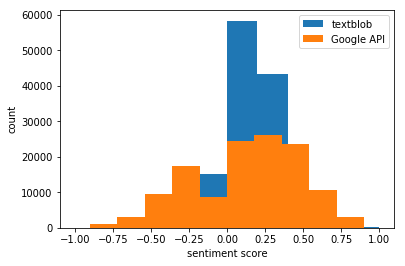

In [37]:
# plot
plt.hist(df['textblob_score'],label="textblob")
plt.hist(df['sentiments'],label="Google API")
plt.xlabel("sentiment score")
plt.ylabel("count")
plt.legend()

We can see that textblob is more concentrated on 0-0.25 range. Google API is more spread which reflects the real situation. **I will choose Google's API**

**Question: What's the relationship between review star and sentiments?**

In [4]:
a = df['review_stars']
a = np.interp(a, (a.min(), a.max()), (-1, +1))

Text(0.5, 1.0, 'review starts vs sentiment')

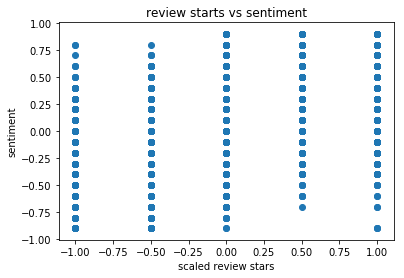

In [6]:
plt.scatter(a,df['sentiments'])
plt.xlabel("scaled review stars")
plt.ylabel("sentiment")
plt.title("review starts vs sentiment")

**It's not clear how they are related. Ideally, we expect high sentiment with how review score. However, this is not the case here.**

**Questions:why there is some reviews having high stars but with low sentiments and vice versa?**

In [78]:
# check the review that has difference of stars and sentiments bigger than 1 
df[abs(a - df['sentiments']) > 1.5].reset_index().loc[1,'text']

'the vacuums suck, that\'s for sure\nsnagged a twenty, inside door\npocket, swept it, straight away\ncest le vie, most would say\nbut I asked, "could it be found?"\n"sure, we\'ll shut, the vacuums down"\nowners, no less, had to go\nto a place, only, Mike Rowe\nof Dirty Jobs, would lurk around\nthe filth, from every car in town\ncollecting, in some giant vat\nwhile they looked, there I sat\nadmiring, this great idea\nand how, ideas, are crystal clear\nto some, but not to others\nbuild a better mouse trap, brother\nwhich they have, at Clean Freak\nget your car washed, on the cheap\npseudo self-serve, shoot the tube\nfelt, just like, some surfer dude\nin a blue wave, closing out\nsoap and suds, sloshed about\nspot free rinse, turtle wax\nspit out, spotless, front to back\nya, I bought, the monthly pass\nbefore, my car, it looked liked ass\nfilthy, crusty, dusty, dirty \nah shucks, now, she sure looks purdy\n\'course Clean Freak\'s got, karma\'s attraction\nfound, returned, my andrew jacks

In [81]:
df[abs(a - df['sentiments']) > 1.5].reset_index().loc[1,['review_stars','sentiments']]

review_stars      5
sentiments     -0.7
Name: 1, dtype: object

**As you can see, some reviews are clearly negative, yet have a 5 star rating and vice versa. These negativities are captured by sentiments and should be considered "dishonest review" which can be detected by the code above.**